<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Exericse_and_Extra-curriculum/%F0%9F%9B%A0_06_Transfer_Learning_in_TensorFlow_Part_3_Scaling_up_Exercise_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 06. Transfer Learning in TensorFlow Part 3: Scaling-up Exercise Solutions 


1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

2. Recreate the first model (the feature extraction model) with mixed_precision turned on.
  - Does it make the model train faster?
  - Does it effect the accuracy or performance of our model?
  - What's the advatanges of using mixed_precision training?
  
3. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁 . 

## Getting the data and a model readdy

In [1]:
# Getting the helper functions 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

--2021-07-06 18:46:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-06 18:46:07 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2021-07-06 18:46:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [2]:
# Importing the packages we need 
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation layers for our model 
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2), 
  preprocessing.RandomHeight(0.2), 
  preprocessing.RandomWidth(0.2), 
  preprocessing.RandomZoom(0.2)
], name="data_augmentation_layers")


In [3]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor="val_accuracy", 
                                                         save_best_only=True) 

In [4]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
# Building a model to compare with 
base_model_0 = tf.keras.applications.EfficientNetB0(include_top= False)
base_model_0.trainable = False 

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape= (224 , 224 , 3) , name='input_layer')
x = data_augmentation(inputs)
x = base_model_0(x , training = False)
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_2D')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names) , activation= 'softmax', name = 'output_layer')(x)

# Packing into a model 
model_0 = tf.keras.Model(inputs , outputs , name = 'model_0')
model_0.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "model_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layers (Se (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2D (GlobalAv (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [6]:
# Compiling the model
model_0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=["accuracy"])

# Fit
history_model_0 = model_0.fit(train_data_all_10_percent,
                                           epochs=5, 
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), 
                                           callbacks=[checkpoint_callback]) 

Epoch 1/5
237/237 [==============================] - 120s 357ms/step - loss: 3.4495 - accuracy: 0.2486 - val_loss: 2.6415 - val_accuracy: 0.4073
Epoch 2/5
237/237 [==============================] - 74s 309ms/step - loss: 2.3308 - accuracy: 0.4689 - val_loss: 2.1839 - val_accuracy: 0.4714
Epoch 3/5
237/237 [==============================] - 65s 271ms/step - loss: 1.9596 - accuracy: 0.5383 - val_loss: 2.0179 - val_accuracy: 0.4995
Epoch 4/5
237/237 [==============================] - 64s 267ms/step - loss: 1.7631 - accuracy: 0.5711 - val_loss: 1.9403 - val_accuracy: 0.5053
Epoch 5/5
237/237 [==============================] - 59s 248ms/step - loss: 1.5991 - accuracy: 0.6067 - val_loss: 1.9101 - val_accuracy: 0.5042


In [7]:
# Evaluating the model 
results_feature_extraction_model_0 = model_0.evaluate(test_data)
results_feature_extraction_model_0

790/790 [==============================] - 87s 111ms/step - loss: 1.7134 - accuracy: 0.5516


[1.7134236097335815, 0.5516039729118347]

In [8]:
base_model_0.trainable = True 

# Refreeze every layer except for the last 7 
for layer in base_model_0.layers[:-7]:
  layer.trainable = False

In [9]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model_0.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [10]:
# Recompiling the model 
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001 / 10) , 
                metrics = ['accuracy'])

In [11]:
# Fine-tune for 5 more epochs
initial_epochs = 5
fine_tune_epochs = 5 + initial_epochs # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_model_0_fine_tune = model_0.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), 
                                                     initial_epoch=history_model_0.epoch[-1]) 

Epoch 5/10
237/237 [==============================] - 65s 245ms/step - loss: 1.3645 - accuracy: 0.6421 - val_loss: 1.9202 - val_accuracy: 0.5048
Epoch 6/10
237/237 [==============================] - 55s 230ms/step - loss: 1.2123 - accuracy: 0.6791 - val_loss: 1.8942 - val_accuracy: 0.5140
Epoch 7/10
237/237 [==============================] - 53s 224ms/step - loss: 1.1266 - accuracy: 0.6986 - val_loss: 1.8831 - val_accuracy: 0.5246
Epoch 8/10
237/237 [==============================] - 53s 221ms/step - loss: 1.0537 - accuracy: 0.7197 - val_loss: 1.8543 - val_accuracy: 0.5294
Epoch 9/10
237/237 [==============================] - 52s 220ms/step - loss: 0.9927 - accuracy: 0.7370 - val_loss: 1.8868 - val_accuracy: 0.5238
Epoch 10/10
237/237 [==============================] - 52s 218ms/step - loss: 0.9357 - accuracy: 0.7522 - val_loss: 1.8936 - val_accuracy: 0.5257


In [12]:
# Evaluating the model results 

results_fine_tune_model_0 = model_0.evaluate(test_data)
results_fine_tune_model_0

790/790 [==============================] - 88s 111ms/step - loss: 1.6073 - accuracy: 0.5807


[1.6073018312454224, 0.5806732773780823]

Alright now we got a model to compare, let's begin our exercise! 

### 1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [13]:
# Building the feature extractor model
base_model_1 = tf.keras.applications.EfficientNetB0(include_top= False)
base_model_1.trainable = False 

# Setup model architecture with trainable top layers 
inputs = layers.Input(shape= (224 , 224 , 3) , name='input_layer')
x = data_augmentation(inputs)
x = base_model_1(x , training = False)
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_2D')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names) , activation= 'softmax', name = 'output_layer')(x)

# Packing into a model 
feature_extractor_model = tf.keras.Model(inputs , outputs , name = 'feature_extractor_model')
feature_extractor_model.summary() 

Model: "feature_extractor_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layers (Se (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_2D (GlobalAv (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
# Compiling the feature extractor model 
feature_extractor_model.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                                optimizer = tf.keras.optimizers.Adam() , 
                                metrics = ['accuracy'])

# Fitting the feature extractor model for 10 epochs
history_feature_extractor_model = feature_extractor_model.fit(train_data_all_10_percent,
                                           epochs=10, 
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data))) 

Epoch 1/10
237/237 [==============================] - 55s 211ms/step - loss: 3.4807 - accuracy: 0.2474 - val_loss: 2.6300 - val_accuracy: 0.4176
Epoch 2/10
237/237 [==============================] - 46s 194ms/step - loss: 2.3506 - accuracy: 0.4642 - val_loss: 2.1918 - val_accuracy: 0.4812
Epoch 3/10
237/237 [==============================] - 47s 196ms/step - loss: 1.9839 - accuracy: 0.5253 - val_loss: 1.9895 - val_accuracy: 0.5095
Epoch 4/10
237/237 [==============================] - 48s 201ms/step - loss: 1.7567 - accuracy: 0.5707 - val_loss: 1.9580 - val_accuracy: 0.5011
Epoch 5/10
237/237 [==============================] - 47s 197ms/step - loss: 1.6054 - accuracy: 0.6075 - val_loss: 1.9251 - val_accuracy: 0.5111
Epoch 6/10
237/237 [==============================] - 46s 192ms/step - loss: 1.4745 - accuracy: 0.6430 - val_loss: 1.8711 - val_accuracy: 0.5146
Epoch 7/10
237/237 [==============================] - 45s 190ms/step - loss: 1.3791 - accuracy: 0.6617 - val_loss: 1.8269 - val_ac

In [15]:
# Evaluating the feature extractor model on test data 
feature_extractor_results = feature_extractor_model.evaluate(test_data)
feature_extractor_results 

790/790 [==============================] - 87s 110ms/step - loss: 1.6279 - accuracy: 0.5670


[1.627851963043213, 0.5669702887535095]

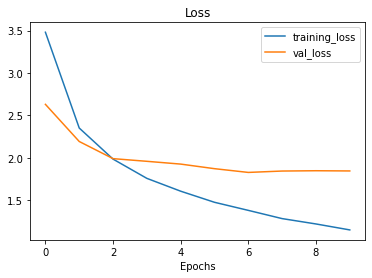

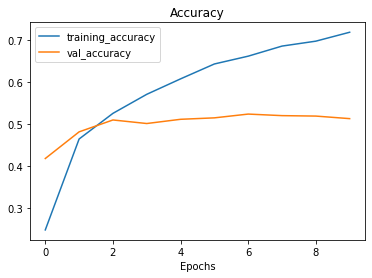

In [16]:
plot_loss_curves(history_feature_extractor_model)

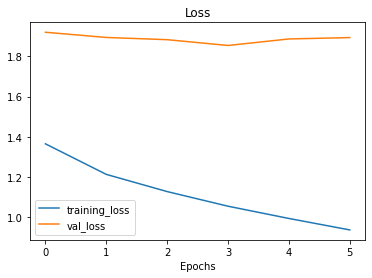

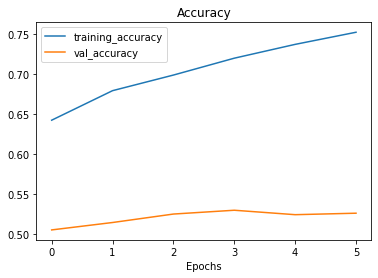

In [17]:
plot_loss_curves(history_model_0_fine_tune)

Looking at the loss curves we can say that the **feature extractor model** which was trained for 10 epochs performing better than the **fine tune model**. 

Though the results might get worse if we fine tune the feature extractor model.